In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D,MaxPooling2D,BatchNormalization,Activation,\
Input,AveragePooling2D,Flatten,Dense,Dropout,concatenate,GlobalAveragePooling2D,\
ZeroPadding2D,Add
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import zipfile
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import random

In [2]:
def extract_zip(source,dest):
  data = zipfile.ZipFile(source,'r')
  data.extractall(dest)
  data.close()


In [3]:
extract_zip('/content/test.csv.zip','/content')
extract_zip('/content/train.csv.zip','/content')

In [4]:
df = pd.read_csv('/content/train.csv')
df.shape

(42000, 785)

In [5]:
X = df.iloc[:,1:].values
Y = df.iloc[:,0:1].values
X = X.reshape(-1,28,28,1)
Y = pd.get_dummies(Y.reshape(-1))
train_x,test_x,train_y,test_y = train_test_split(X,Y,test_size=.15,random_state=10) 

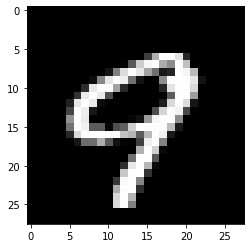

In [6]:
plt.imshow(X[100,:].reshape(28,28),cmap="gray")

In [7]:
def InceptionBlock(x,Conv1x1,Conv3x3Reduce,Conv3x3,Conv5x5Reduce,Conv5x5,Conv1x1After):
  Conv1x1Layer = Conv2D(Conv1x1,(1,1),(1,1),'same',activation='relu')(x)
  Conv3x3Reduce = Conv2D(Conv3x3Reduce,(1,1),(1,1),'same',activation='relu')(x)
  Conv5x5Reduce = Conv2D(Conv5x5Reduce,(1,1),(1,1),'same',activation='relu')(x)
  MaxPoolLayer = MaxPooling2D((3,3),(1,1),'same')(x)
  Conv3x3Layer = Conv2D(Conv3x3,(3,3),(1,1),'same',activation='relu')(Conv3x3Reduce)
  Conv5x5Layer = Conv2D(Conv5x5,(5,5),(1,1),'same',activation='relu')(Conv5x5Reduce)
  Conv1x1AfterMax = Conv2D(Conv1x1After,(1,1),(1,1),'same',activation='relu')(MaxPoolLayer)
  return concatenate([Conv1x1Layer,Conv3x3Layer,Conv5x5Layer,Conv1x1AfterMax],axis=3)
  


def InceptionV1():
  Input_layer = Input((28,28,1))
  x = Conv2D(64,(3,3),(1,1),'same',activation='relu')(Input_layer)
  x = MaxPooling2D((2,2),(1,1),padding='same')(x)
  x = Conv2D(192,(3,3),(1,1),'same',activation='relu')(Input_layer)
  x = MaxPooling2D((2,2),(1,1),padding='same')(x)
  x = InceptionBlock(x,64,96,128,16,32,32)
  x = InceptionBlock(x,128,128,192,32,96,64)
  x = MaxPooling2D((3,3),(2,2),'same')(x)
  x = InceptionBlock(x,192,96,208,16,48,64)
  x1 = AveragePooling2D((5,5),strides=3)(x)
  x1 = Conv2D(128,(1,1),padding='same',activation='relu')(x1)
  x1 = Flatten()(x1)
  x1 = Dense(1024, activation='relu')(x1)
  x1 = Dropout(.3)(x1)
  x1 = Dense(10, activation='softmax')(x1)
  x = InceptionBlock(x,160,112,224,24,64,64)
  x = InceptionBlock(x,128,128,256,24,64,64)
  x = InceptionBlock(x,112,144,288,32,64,64)
  x2 = AveragePooling2D((5, 5), strides=3)(x)
  x2 = Conv2D(128, (1, 1), padding='same', activation='relu')(x2)
  x2 = Flatten()(x2)
  x2 = Dense(1024, activation='relu')(x2)
  x2 = Dropout(0.3)(x2)
  x2 = Dense(10, activation='softmax')(x2)
  x = InceptionBlock(x,256,160,320,32,128,128)
  x = MaxPooling2D((3,3),(2,2),'same')(x)
  x = InceptionBlock(x,256,160,320,32,128,128)
  x = InceptionBlock(x,384,192,384,48,128,128)
  x = GlobalAveragePooling2D()(x)
  x = Dropout(.4)(x)
  x = Dense(10,'softmax')(x)
  model = Model(Input_layer,[x,x1,x2])
  return model

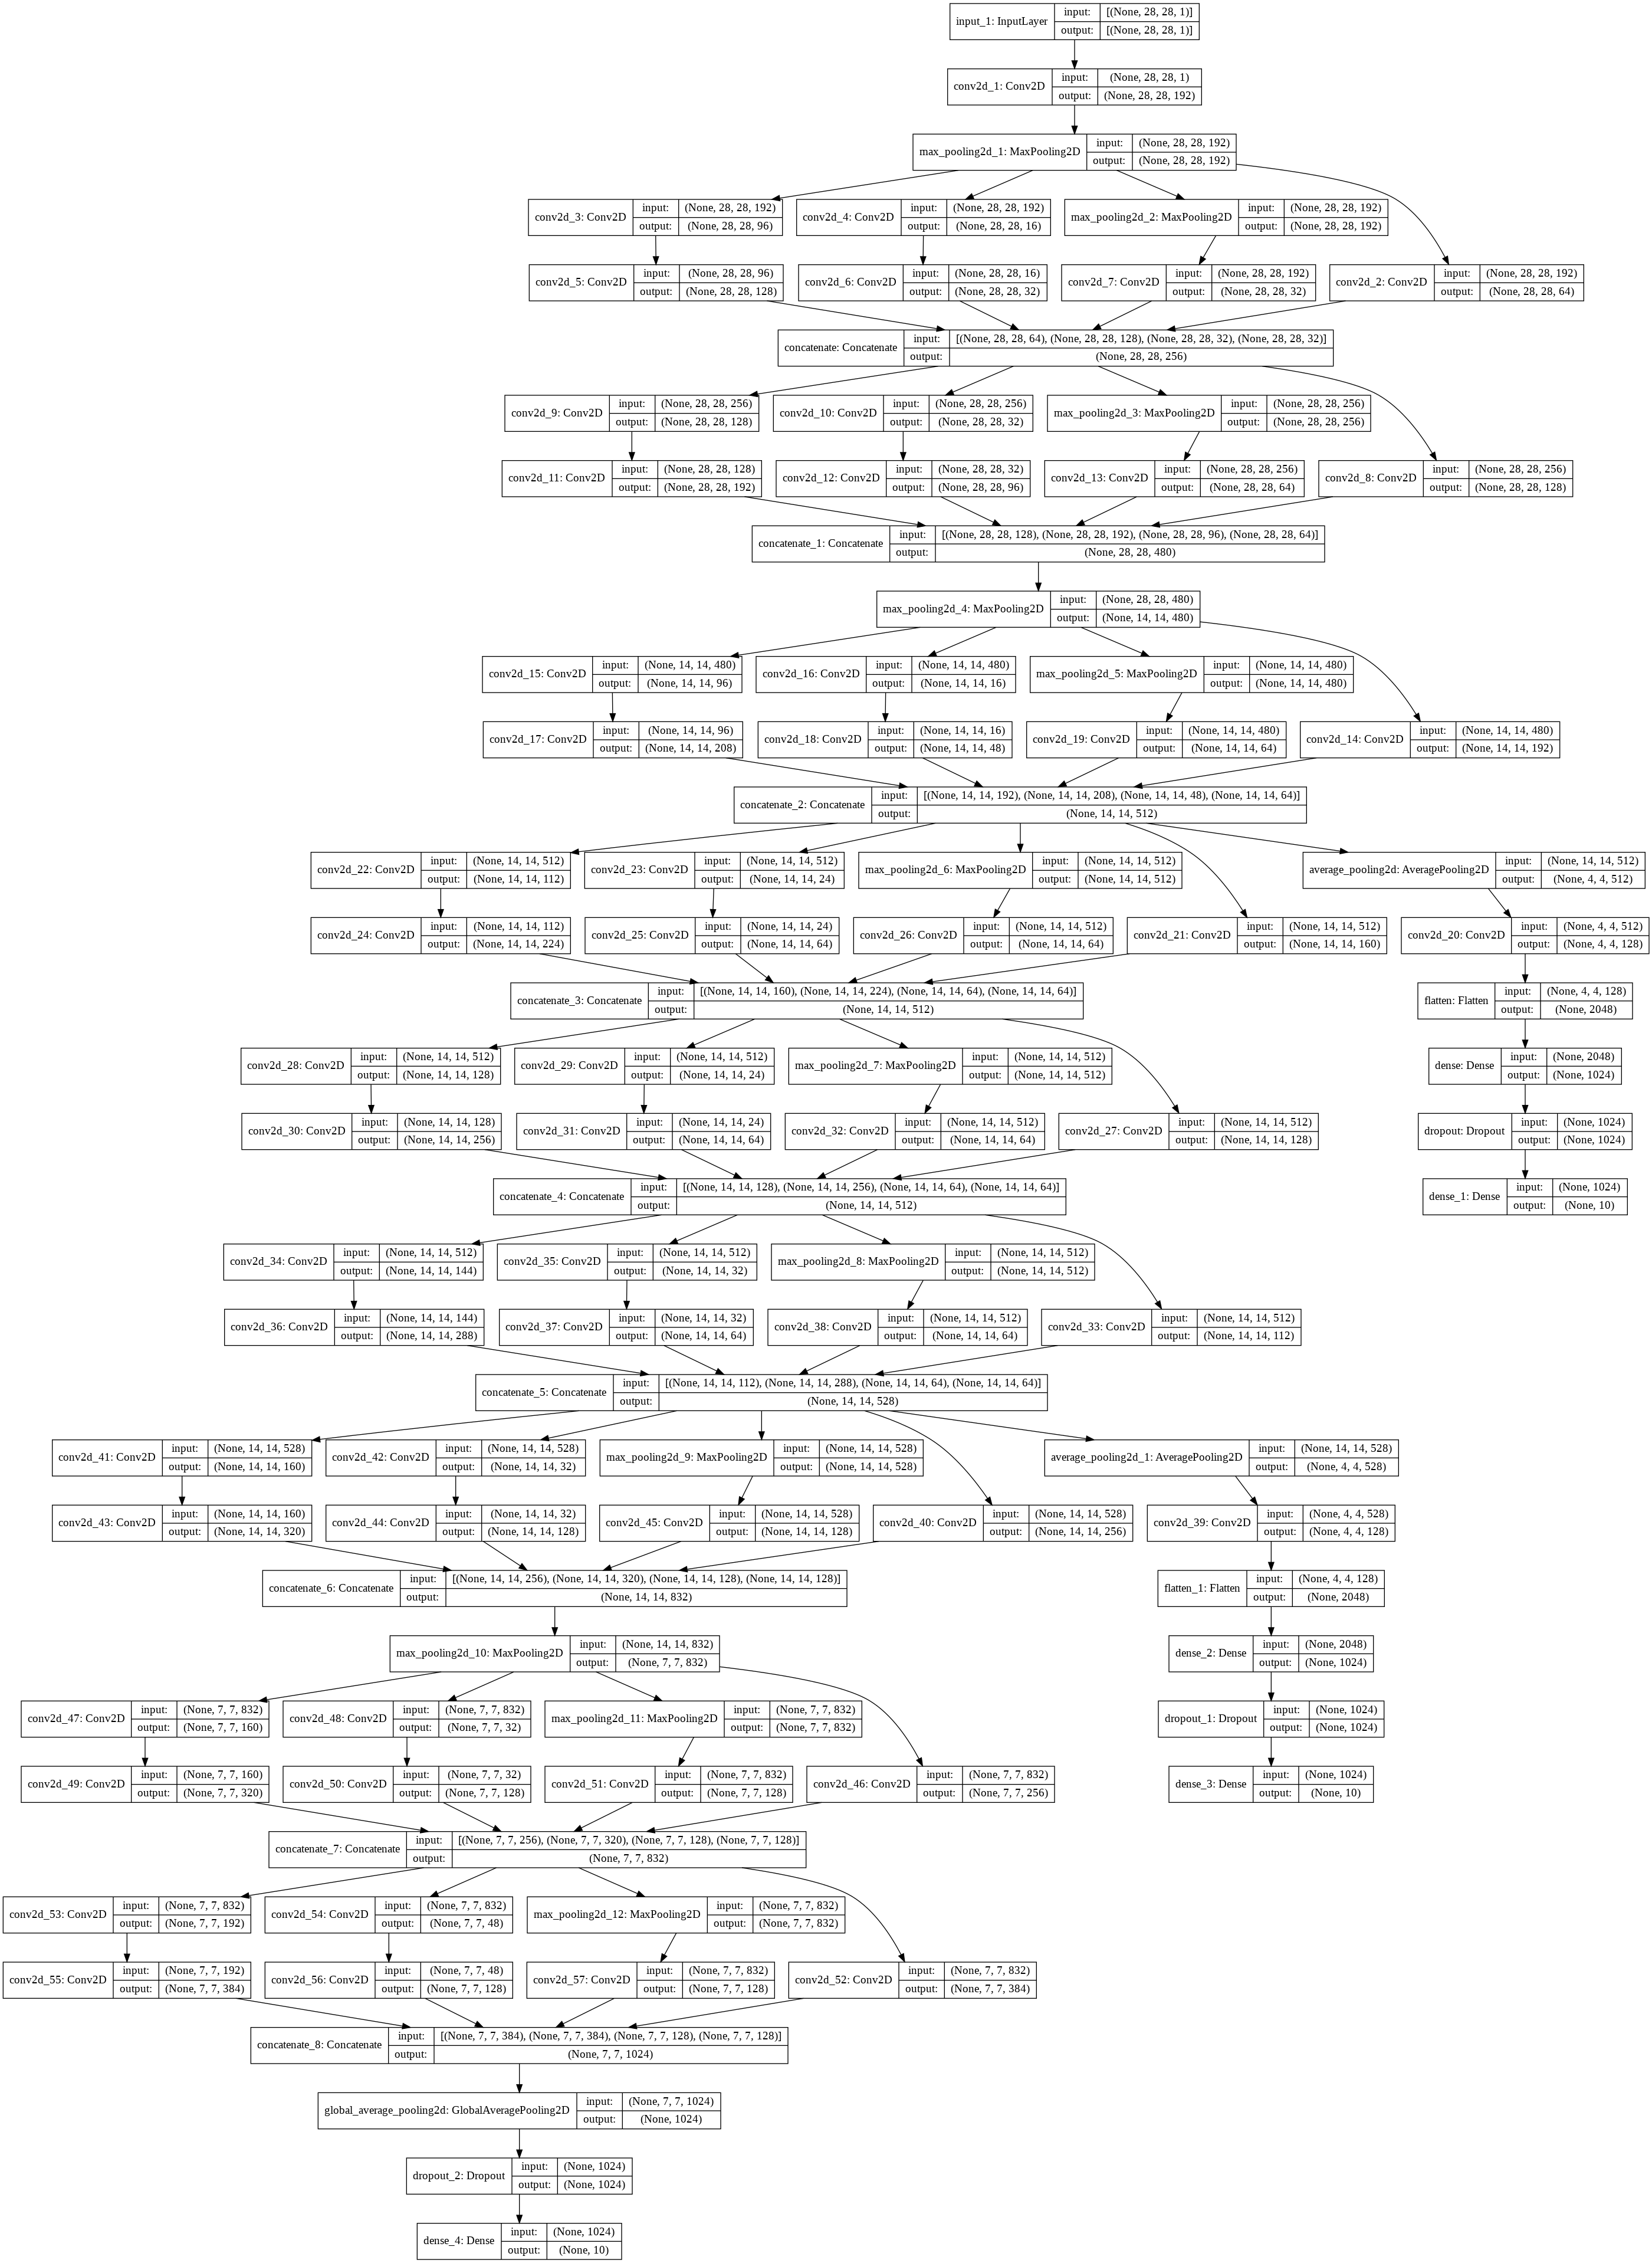

In [8]:
model = InceptionV1()
# model.summary()
plot_model(model,to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [9]:
model.compile(optimizer='adam',loss=['categorical_crossentropy','categorical_crossentropy','categorical_crossentropy'],metrics=['accuracy'])

In [10]:
model.fit(train_x,[train_y,train_y,train_y],epochs=10,batch_size=256,validation_data=(test_x,[test_y,test_y,test_y]))

Epoch 1/10
140/140 [==============================] - 99s 642ms/step - loss: 5.2599 - dense_4_loss: 2.0127 - dense_1_loss: 1.7553 - dense_3_loss: 1.4919 - dense_4_accuracy: 0.3735 - dense_1_accuracy: 0.6615 - dense_3_accuracy: 0.5976 - val_loss: 0.3195 - val_dense_4_loss: 0.1529 - val_dense_1_loss: 0.0751 - val_dense_3_loss: 0.0915 - val_dense_4_accuracy: 0.9548 - val_dense_1_accuracy: 0.9760 - val_dense_3_accuracy: 0.9705
Epoch 2/10
140/140 [==============================] - 85s 607ms/step - loss: 0.3040 - dense_4_loss: 0.1506 - dense_1_loss: 0.0699 - dense_3_loss: 0.0835 - dense_4_accuracy: 0.9549 - dense_1_accuracy: 0.9791 - dense_3_accuracy: 0.9747 - val_loss: 0.1789 - val_dense_4_loss: 0.0913 - val_dense_1_loss: 0.0390 - val_dense_3_loss: 0.0487 - val_dense_4_accuracy: 0.9706 - val_dense_1_accuracy: 0.9863 - val_dense_3_accuracy: 0.9835
Epoch 3/10
140/140 [==============================] - 85s 606ms/step - loss: 0.1802 - dense_4_loss: 0.0842 - dense_1_loss: 0.0435 - dense_3_loss: 

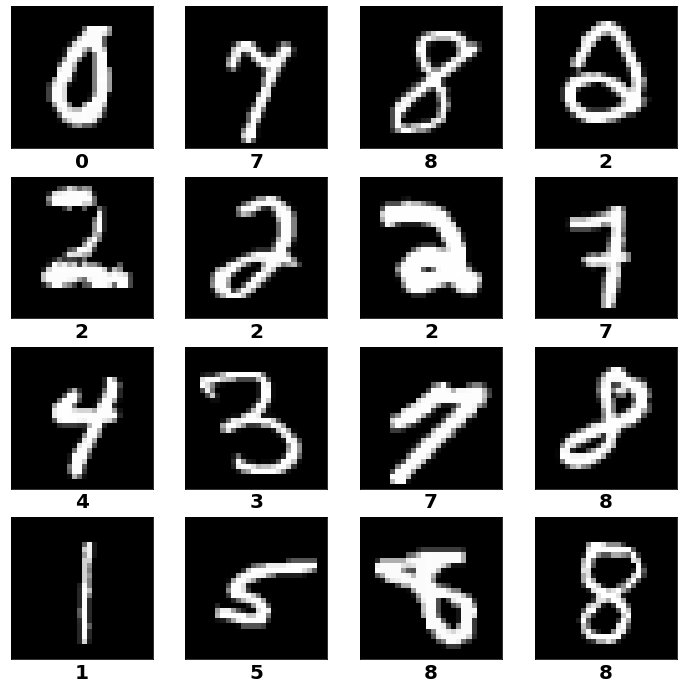

In [12]:
fig,axes = plt.subplots(nrows=4,ncols=4,figsize=(12,12));
# print(axes)
for ax in axes:
  for col in ax:
    index = random.randint(1,6300)
    pred = model.predict(np.expand_dims(test_x[index-1],0))
    max = [np.amax(pred[0]),np.amax(pred[1]),np.amax(pred[2])]
    maxi = np.argmax(max)
    label = np.argmax(pred[maxi])
    col.set_xlabel(label,fontdict={'size':20,"weight":'bold'})
    col.set_xticks([])
    col.set_yticks([])
    col.imshow(test_x[index-1].reshape(28,28),cmap='gray')
fig.savefig('result.png')

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(train_x,train_y,epochs=10,batch_size=256,validation_data=(test_x,test_y))